# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Final Project: Modeling COVID-19 in the US

### Group 58 Team Member: Yuchen, Yichun, Ziyi, Moni

**Harvard University**<br/>
**Fall 2020**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2.4pt">

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split

import matplotlib.dates as mdates
from datetime import datetime


from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn.decomposition import PCA



from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.inspection import permutation_importance
import xgboost as xgb

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras import models
import keras.backend as K

import statsmodels.api as sm
import xlrd
import warnings
import timeit
import eli5
from eli5.sklearn import PermutationImportance
import lime
from lime.lime_tabular import LimeTabularExplainer


C:\Users\TANG\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\TANG\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


<a id="Contents"></a>
## Structure of our notebook: 
- [1. Data collection, cleaning](#Q1)
<br> - [1.1 Data input](#Q1.1)
<br> - [1.2 Merge data](#Q1.2)


- [2. Early stage prediction and counterfactual simulations](#Q2)
<br> - [2.1 Define Key Functions](#Q2.1)
<br> - [2.2 Build models](#Q2.2)
<br> - [2.3 Train models](#Q2.3)
<br> - [2.4 Prediction](#Q2.4)
<br> - [2.5 Result display](#Q2.5)
<br> - [2.6 Counterfactual simulations](#Q2.6)
<br> - Model used: linear regression; decision tree; random forest; boosting


- [3. Re-opening and second wave](#Q3)
<br> - [3.1 Define second wave](#Q3.1)
<br> - [3.2 Prepare predictors](#Q3.2)
<br> - [3.3 Train models and prediction](#Q3.3)
<br> - [3.4 Model interpretation](#Q3.4)
<br> - Model used: logistics regression; lasso logistics; PCA; random forest; boosting; ANN


- [4. Mobility & face mask policy](#Q4)
<br> - [4.1 ](#Q4.1)




<a id="Q1"></a>

# 1. Data collection, cleaning
[▲ Return to contents](#Contents)

<a id="Q1.1"></a>
## 1.1 Data input
[▲ Return to contents](#Contents)

#### 1.1.1 Socio-demographic Data

In [4]:
# Socio-demographic Data

df_sd = pd.read_csv("../../../02_Data//02_SociaDemographics/us_final.csv",index_col=0)
df_sd = df_sd.reset_index()
df_sd_og=df_sd.copy()

# Process files
df_sd = df_sd[df_sd['state']!="Puerto Rico"]
df_sd = df_sd.dropna(subset=['democrat',"Crime_ARSON"])
df_sd.drop(columns=['index','lat','long'],inplace=True)

# ===== ===== ===== ===== =====
# Processed Data
# Output: df_sd

#### 1.1.2 Cases Data

Smooth the cases data with a 7-day moving average before growth rate calculation. 

In [5]:
# Cases Data

df_case = pd.read_csv("../../../02_Data//01_COVID/covid_us_county.csv")
df_case.dropna(inplace=True)
df_case = df_case[['fips','lat','long','date','cases','deaths']]
df_case['fips'] = df_case.fips.astype(int)

def Seven_Day_Moving_Average(df,minimum_case=10):
    df_c = df.copy()
    fips = list(set(df_c['fips']))
    
    mData = []
    for fip in tqdm(fips):
        df = df_c[df_c['fips']==fip]
        df = df[df['cases']>=minimum_case]
        df = df.reset_index(drop=True)
        df = df.reset_index()
        
        df = df.to_dict('records')
        # 7 day moving average
        for i in range(len(df)-6):
            mdf = df[i:i+7]
            mdf_case = [m['cases'] for m in mdf]
            mdf_death = [m['deaths'] for m in mdf]
            df[i+3]['cases_7'] = np.sum(mdf_case)/7
            df[i+3]['deaths_7'] = np.sum(mdf_death)/7
            df[i+3]['day_index'] = df[i+3]['index']
            mData.append(df[i+3])
    
    # Log growth rate
    for i in range(len(mData)-1):
        mData[i+1]['delta_case'] = np.log(mData[i+1]['cases_7']) - np.log(mData[i]['cases_7'])
        pass
    del mData[0]
    return pd.DataFrame(mData)

df_case_delta = Seven_Day_Moving_Average(df_case)
df_case_delta.to_csv("../../../02_Data/01_COVID/_7_day_average.csv")
df_case_delta['date'] = pd.to_datetime(df_case_delta['date'])
df_case_delta['month'] = df_case_delta['date'].dt.month
df_case_delta["George_Floyd"] = 0
df_case_delta.loc[df_case_delta['date']>="2020-05-25",'George_Floyd'] = 1

# ===== ===== ===== ===== =====
# Processed Data
# Output: df_case_delta

100%|█████████████████████████████████████████████████████████████████████████████| 3241/3241 [00:30<00:00, 107.33it/s]


#### 1.1.3 Weather Data

In [6]:
# Weather Data

df_weather = pd.read_csv("../../../02_Data//06_Weather//us_weather_final.csv")
df_weather = df_weather[['fips','av_tem','month']]
df_weather = df_weather.rename(columns={'tem_rank':"rank"})

# ===== ===== ===== ===== =====
# Processed Data
# Output: df_weather

#### 1.1.4 Policy Data

In [7]:
# Policy Data
df_policy = pd.read_excel(r"../../../02_Data\03_Policy\COVID_StatePolicy_final.xlsx")
df_policy_og = df_policy.copy()
temp_case = pd.read_csv(r"../../../02_Data\01_COVID\covid_us_county.csv")
temp_case.dropna(inplace=True)
temp_case = temp_case[['fips','lat','long','date','cases','deaths','state_code','state']]
temp_case['fips'] = temp_case.fips.astype(int)
df_policy=temp_case.merge(df_policy, on=['state_code','state'],how='left')

df_policy['date_object'] = df_policy['date']
df_policy['date'] = df_policy['date'].astype('datetime64[ns]')

df_policy['policy_home']=np.where((df_policy['date']>=df_policy['stay_at_home']) 
                                 & (df_policy['date']<=df_policy['end_stay_at_home'])
                                 , 1, 0)
df_policy['policy_school']=np.where((df_policy['date']>=df_policy['close_school']), 1, 0)
df_policy['policy_business']=np.where((df_policy['date']>=df_policy['close_nonessential_business']) 
                                 & (df_policy['date']<=df_policy['reopen_business']), 1, 0)
df_policy['policy_restaurant']=np.where((df_policy['date']>=df_policy['close_restaurant']) 
                                 & (df_policy['date']<=df_policy['reopen_restaurant']), 1, 0)
df_policy['policy_facemask']=np.where((df_policy['date']>=df_policy['facemask']), 1, 0)
df_policy['policy_gym']=np.where((df_policy['date']>=df_policy['close_gym']) 
                                 & (df_policy['date']<=df_policy['reopen_gym']), 1, 0)
df_policy['policy_theater']=np.where((df_policy['date']>=df_policy['close_theater']) 
                                 & (df_policy['date']<=df_policy['reopen_theater']), 1, 0)
df_policy['policy_bar']=np.where((df_policy['date']>=df_policy['close_bar']) 
                                 & (df_policy['date']<=df_policy['reopen_bar']), 1, 0)

df_policy['date'] = pd.to_datetime(df_policy['date'])
df_policy = df_policy[['fips','date','policy_home','policy_school','policy_business','policy_restaurant','policy_facemask','policy_gym','policy_theater','policy_bar']]

# ===== ===== ===== ===== =====
# Processed Data
# Output: df_policy

#### 1.1.5 Mobility Data

In [8]:
# Mobility
county_df = pd.read_csv("../../../02_Data/05_Mobility/US_Regional_Mobility_Report1.csv")
cases_df = pd.read_csv("../../../02_Data/01_Covid/covid_us_county.csv")
cases_df1 = pd.read_csv("../../../02_Data/01_Covid/covid_county_Beat1.csv")
df_mobility = pd.read_csv("../../../02_Data//05_Mobility/2020_US_Region_Mobility_Report.csv")
df_mobility_processed = df_mobility.drop(labels=['census_fips_code','metro_area','country_region_code', 'country_region'], axis=1)
df_mob = pd.read_csv("../../../02_Data//05_Mobility/2020_US_Region_Mobility_Report.csv")
df_mob = df_mob.drop(labels='census_fips_code', axis=1)
df_mob['metro_area'].notnull().values.any()

# there are 6 different place categories provided by google mobility, so let's store them in a simple list.
mobility_predictors = df_mobility_processed.columns[4:].tolist()
mobility_fontsize = 30

# check how many rows have values for all 6 predictors
df_mobility_processed_2 = df_mobility_processed.loc[df_mobility_processed[mobility_predictors[0]].notnull() & df_mobility_processed[mobility_predictors[1]].notnull() & df_mobility_processed[mobility_predictors[2]].notnull() &
       df_mobility_processed[mobility_predictors[3]].notnull() & df_mobility_processed[mobility_predictors[4]].notnull() & df_mobility_processed[mobility_predictors[5]].notnull()]
df_mobility_processed_2 = df_mobility_processed_2.loc[df_mobility_processed['sub_region_1'].isnull()]

# ===== ===== ===== ===== =====
# Processed Data
# Output: county_df1, df_mobility_processed_2

#### 1.1.6 Facemask Data

In [9]:
# facemask
df_facemask = pd.read_csv(r"../../../02_Data/07_Facemask/county_facemask.csv",index_col=0)
df_facemask['facemask_score']=1*df_facemask['facemask_never']+2*df_facemask['facemask_rarely']+3*df_facemask['facemask_sometimes']+4*df_facemask['facemask_frequently']+5*df_facemask['facemask_always']
df_facemask=df_facemask.drop(columns='countyfp')

# ===== ===== ===== ===== =====
# Processed Data
# Output: df_facemask

<a id="Q1.2"></a>
## 1.2 Merge Data
[▲ Return to contents](#Contents)

In [8]:
print(df_sd.shape)
df_merge = pd.merge(df_sd,df_case_delta,left_on="fips",right_on="fips",how='left')
print(df_merge.shape)
df_merge = pd.merge(df_merge,df_weather,left_on=["fips",'month'],right_on=["fips",'month'],how='left')
print(df_merge.shape)
df_merge = pd.merge(df_merge,df_policy,left_on=["fips",'date'],right_on=["fips",'date'],how='left')
print(df_merge.shape)
df_policy_merge = df_merge.copy()

d =df_merge[(df_merge['fips']==1015)&(df_merge['date']<"2020-05-01")]
# print(df_policy.info())
# print(df_weather.info())

# None float/int variable
df_merge = df_merge.drop(columns=['county','state','state_code','IDNO','index'])

# High collinearity
df_merge = df_merge.drop(columns=['VotingAgeCitizen','Income','IncomeErr','Poverty','ChildPoverty'])
df_merge = df_merge.drop(columns=['Crime_CPOPARST','Crime_CPOPCRIM','Crime_AG_ARRST','Crime_AG_OFF','Crime_COVIND',
                                  'Crime_MODINDX','Crime_MURDER','Crime_RAPE','Crime_ROBBERY','Crime_AGASSLT','Crime_BURGLRY',
                                  'Crime_LARCENY','Crime_BURGLRY','Crime_MVTHEFT','Crime_ARSON'])

# Not using feature
df_merge = df_merge.drop(columns=['cases','deaths','deaths_7','month','democrat'])

# Same Group
# df_merge = df_merge.drop(columns=['Race_White'])
# df_merge = df_merge.drop(columns=['WorkType_Office'])
# df_merge = df_merge.drop(columns=['Transp_Drive'])
# df_merge = df_merge.drop(columns=['Work_PublicWork'])

# Temp removal
df_merge = df_merge.drop(columns=['av_tem'])

# pd.set_option('display.max_columns', None)
# print(df_merge.columns.values)
# print(len(df_merge.columns.values))
# print(df_merge.describe())

# print(df_merge.info())

(3113, 56)
(527502, 68)
(527502, 69)
(527502, 77)


In [9]:
# Save to CSV
df_merge.to_csv("../../../02_Data/01_COVID/merged_case.csv")

<a id="Q2"></a>
# 2. Early stage prediction and counterfactual simulations
[▲ Return to contents](#Contents)


<a id="Q2.1"></a>
## 2.1 Define Key Functions
[▲ Return to contents](#Contents)

In [10]:
def Save_Model(model, directory):
    joblib.dump(model,"./weights/"+directory)
    
def keras_r2(y_true,y_pred):
    y_mean=K.mean(y_true)
    # ssreg=K.sum((y_pred-y_mean)**2)
    sstotal=K.sum((y_true-y_mean)**2) # denominator
    ssres=K.sum((y_true-y_pred)**2)  # numerator
    score = 1-(ssres/sstotal)
    return score

def Generate_Period_Data(df,start_date, end_date, minimum_case=10):
    minimum_case = 10

    df_to_split = df[(df['date']>=start_date)&(df['date']<end_date)&(df['cases_7']>=minimum_case)&(df['delta_case']>=0)]
    
    x = df_to_split.drop(columns=['delta_case'])
    y = df_to_split['delta_case']
    
#     df_to_split.drop(columns=['delta_case'],inplace=True)
#     x = df_to_split.drop(columns=['beta_1'])
#     y = df_to_split['beta_1']  
    return x,y

def Split_Dataset(x,y,test_size=0.3,scaler_output=True,directory="./weights/temp.pkl"):
    X_train,X_test, y_train, y_test = train_test_split(x,y,test_size=test_size,random_state=5)

    X_train_info = X_train[['fips','date','cases_7']]
    X_train = X_train.drop(columns=['fips','date','cases_7'])
    X_test_info = X_test[['fips','date','cases_7']]
    X_test = X_test.drop(columns=['fips','date','cases_7'])

    # ===== ===== ===== ===== =====
    # Standardized
    scaler = StandardScaler().fit(X_train)
    X_train_std = X_train.copy()
    X_test_std = X_test.copy()

    columns = X_train.columns
    X_train_std[columns] = scaler.transform(X_train[columns])
    X_test_std[columns] = scaler.transform(X_test[columns])

    if scaler_output:
        with open(directory,'wb') as f:
            pickle.dump(scaler,f)
    
    return X_train, X_train_std, X_train_info,y_train,X_test, X_test_std, X_test_info,y_test

class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        current_R2 = logs.get("val_keras_r2")
        if current<0.07 and current_R2>=0.875:
            self.model.stop_training = True

def Train_NN(p_x_train,p_y_train,p_x_test,p_y_test,epochs=500,model_output=True, directory="../weights/temp_model",verbose=0):
    print(f"Train Size:{p_x_train.shape}")
    print(f"Test Size:{p_x_test.shape}")
    MLP= models.Sequential(name="MLP")
    MLP.add(layers.Dense(256, activation='sigmoid',input_shape=(43,), name="input"))
    MLP.add(layers.Dropout(0.15))
    MLP.add(layers.Dense(128, activation='sigmoid', name='hidden_1'))
    MLP.add(layers.Dense(1, name='output'))
    MLP.compile(optimizer=optimizers.Adam(lr=0.005),loss='mean_squared_error',metrics=[keras_r2])

    test_size = p_x_test.shape[0]
    history_MLP = MLP.fit(p_x_train, p_y_train*10, verbose=verbose,epochs=epochs, validation_data=(p_x_test, p_y_test*10),batch_size=128)
    
    if model_output:
        if os.path.exists(directory):
            pass
        else:
            os.mkdir(directory)
        MLP.save(directory)
    
    return MLP, history_MLP

def Load_NN(directory):
    MLP = keras.models.load_model(directory)
    return MLP

def Print_R2(history):
    # ===== ===== ===== ===== =====
    # Display Loss
    history_display = history.history
    print(f"Max R2 train: {max(history_display['keras_r2'])}")
    print(f"Min loss train: {min(history_display['loss'])}")
    print(f"Max R2 valid: {max(history_display['val_keras_r2'])}")
    print(f"Min loss valid: {min(history_display['val_loss'])}")

    plt.figure(figsize=(16,9))
    plt.plot(history_display['loss'],"b",label="train loss")
    plt.plot(history_display['val_loss'],"r",label="validation loss")
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend()
    plt.title("Loss acorss epochs",fontsize=20)
    plt.show()
    

<a id="Q2.2"></a>
## 2.2 Build Models
[▲ Return to contents](#Contents)

#### 2.2.1 Model-1: LinearRegression

In [11]:
start_date = "2020-03-01"
end_date = "2020-10-01"

X,y = Generate_Period_Data(df_merge,start_date,end_date, minimum_case=10)
X_train, X_train_std, X_train_info,y_train,X_test, X_test_std, X_test_info,y_test = Split_Dataset(X,y,directory=f"./weights/scaler_{start_date}_{end_date}.pkl")

model_lr = LinearRegression()
model_lr.fit(X_train,y_train)

train_pred = model_lr.predict(X_train)
# valid_pred = model_lr.predict(X_valid)
test_pred = model_lr.predict(X_test)

mse_score_lr_train = mean_squared_error(model_lr.predict(X_train), y_train)
# mse_score_lr_valid = mean_squared_error(model_lr.predict(X_valid), y_valid)
mse_score_lr_test = mean_squared_error(model_lr.predict(X_test), y_test)
r2_score_lr_train = r2_score(train_pred,y_train)
# r2_score_lr_valid = r2_score(valid_pred,y_valid)
r2_score_lr_test = r2_score(test_pred,y_test)


print(f"Linear Regression MSE on trainset is {mse_score_lr_train:.4f}")
# print(f"Linear Regression MSE on validset is {mse_score_lr_valid:.4f}")
print(f"Linear Regression MSE on testset is {mse_score_lr_test:.4f}")
print(f"Linear Regression R2 on trainset is {r2_score_lr_train:.4f}")
# print(f"Linear Regression R2 on validset is {r2_score_lr_valid:.4f}")
print(f"Linear Regression R2 on testset is {r2_score_lr_test:.4f}")
# print(model_lr.coef_)
# print(model_lr.intercept_)

Linear Regression MSE on trainset is 0.0007
Linear Regression MSE on testset is 0.0007
Linear Regression R2 on trainset is -2.4767
Linear Regression R2 on testset is -2.4694


In [12]:
def KNNRegression(x_train,y_train,x_test,y_test):
    train_score_2 = []
    test_score_2 = []
    K_2 = [1,3,5,7,10,15,20,30]

    for k in tqdm(K_2):

        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(x_train,y_train)
        y_pred_train = model.predict(x_train)
        y_pred_test = model.predict(x_test)
        train_score = mean_squared_error(y_pred_train,y_train)
        test_score = mean_squared_error(y_pred_test,y_test)

        y_pred_class_train = 1*(y_pred_train>=0.5)
        y_pred_class_test = 1*(y_pred_test>=0.5)

        y_pred_match_train = np.sum(y_pred_class_train==y_train)
        y_pred_match_test = np.sum(y_pred_class_test==y_test)

        y_accuracy_train = y_pred_match_train / len(y_train)
        y_accuracy_test = y_pred_match_test / len(y_test)
        train_score_2.append(y_accuracy_train)
        test_score_2.append(y_accuracy_test)
        pass

    best_k_index = np.argmax(test_score_2)
    print(f"KNN Train Accuracy = {train_score_2[best_k_index]:.4f}")
    print(f"KNN Test Accuracy = {test_score_2[best_k_index]:.4f}")

    plt.figure(figsize=(16,9))
    plt.plot(K_2,train_score_2,"b",label="train accuracy")
    plt.plot(K_2,test_score_2,"r",label="valid accuracy")
    plt.vlines(K_2[best_k_index],np.min(test_score_2), np.max(train_score_2), linestyles ="dotted", colors ="g",label=f"best k = {K_2[best_k_index]}")
    plt.xlabel("Value of k", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.legend()
    plt.title("Accuracy acorss Ks",fontsize=20)

#### 2.2.2 Model-2: Decision Tree

In [13]:
def DecisionTree(x_train,y_train,x_test,y_test,max_depth):
    model_dt = DecisionTreeRegressor(max_depth=max_depth)
    model_dt.fit(x_train,y_train)

    train_pred = model_dt.predict(x_train)
    # valid_pred = model_dt.predict(X_valid)
    test_pred = model_dt.predict(x_test)

    mse_score_lr_train = mean_squared_error(train_pred, y_train)
    # mse_score_lr_valid = mean_squared_error(valid_pred, y_valid)
    mse_score_lr_test = mean_squared_error(test_pred, y_test)
    r2_score_lr_train = r2_score(train_pred,y_train)
    # r2_score_lr_valid = r2_score(valid_pred,y_valid)
    r2_score_lr_test = r2_score(test_pred,y_test)

    print(f"Decision Tree MSE on trainset is {mse_score_lr_train:.4f}")
    print(f"Decision Tree MSE on testset is {mse_score_lr_test:.4f}")
    print(f"Decision Tree R2 on trainset is {r2_score_lr_train:.4f}")
    print(f"Decision Tree R2 on testset is {r2_score_lr_test:.4f}")

In [14]:
def DecisionTreeMultiple(x_train,y_train,x_test,y_test,depths=[1,2,3,5,7,10,15,20,30,40,50,70,100]):
    train_score_7 = []
    test_score_7 = []
    D_7 = depths

    for d in tqdm(D_7):

        model = DecisionTreeRegressor(max_depth=d)
        model.fit(x_train,y_train)

        y_accuracy_train_7 = model.score(x_train, y_train)
        y_accuracy_test_7 = model.score(x_test, y_test)

        train_score_7.append(y_accuracy_train_7)
        test_score_7.append(y_accuracy_test_7)
        pass

    best_d_index = np.argmax(test_score_7)
    print(f"Decision Tree Train Accuracy = {train_score_7[best_d_index]:.4f}")
    print(f"Decision Tree Test Accuracy = {test_score_7[best_d_index]:.4f}")

    plt.figure(figsize=(16,9))
    plt.plot(D_7,train_score_7,"b",label="train accuracy")
    plt.plot(D_7,test_score_7,"r",label="valid accuracy")
    plt.vlines(D_7[best_d_index],np.min(test_score_7), np.max(train_score_7), linestyles ="dotted", colors ="g",label=f"best depth = {D_7[best_d_index]}")
    plt.xlabel("Value of max depth", fontsize=16)
    plt.ylabel("Accuracy", fontsize=16)
    plt.legend()
    plt.title("Accuracy acorss Depths",fontsize=20)

#### 2.2.3 Model-3: RandomForest

In [15]:
def RandomForest(x_train,y_train,x_test,y_test,max_depth):
    model = RandomForestRegressor(max_depth=max_depth, n_estimators=100, max_features="sqrt")
    model.fit(x_train,y_train)

    y_accuracy_train_10 = model.score(x_train, y_train)
    y_accuracy_test_10 = model.score(x_test, y_test)

    print(f"Bagging Train Accuracy = {y_accuracy_train_10:.4f}")
    print(f"Bagging Test Accuracy = {y_accuracy_test_10:.4f}")
    Save_Model(model,"RandomForest.pkl")

#### 2.2.4 Model-4: Boosting

In [16]:
def Adaboost(x_train,y_train,x_test,y_test,max_depth):
    model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=max_depth),learning_rate=0.05,n_estimators=100)
    model.fit(x_train,y_train)
    y_accuracy_train_8 = model.score(x_train, y_train)
    y_accuracy_test_8 = model.score(x_test, y_test)

    print(f"Bagging Train Accuracy = {y_accuracy_train_8:.4f}")
    print(f"Bagging Test Accuracy = {y_accuracy_test_8:.4f}")

<a id="Q2.3"></a>
## 2.3 Train the Model
[▲ Return to contents](#Contents)

Train Size:(313595, 43)
Test Size:(134397, 43)
Epoch 1/500
2450/2450 [==============================] - 6s 2ms/step - loss: 0.0751 - keras_r2: 0.3474 - val_loss: 0.0617 - val_keras_r2: 0.4827
Epoch 2/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0600 - keras_r2: 0.4776 - val_loss: 0.0571 - val_keras_r2: 0.5085
Epoch 3/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0574 - keras_r2: 0.5033 - val_loss: 0.0582 - val_keras_r2: 0.4773
Epoch 4/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0549 - keras_r2: 0.5212 - val_loss: 0.0526 - val_keras_r2: 0.5497
Epoch 5/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0531 - keras_r2: 0.5321 - val_loss: 0.0512 - val_keras_r2: 0.5600
Epoch 6/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0518 - keras_r2: 0.5399 - val_loss: 0.0498 - val_keras_r2: 0.5564
Epoch 7/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0501

Epoch 57/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0371 - keras_r2: 0.6680 - val_loss: 0.0355 - val_keras_r2: 0.6824
Epoch 58/500
2450/2450 [==============================] - 6s 2ms/step - loss: 0.0364 - keras_r2: 0.6691 - val_loss: 0.0415 - val_keras_r2: 0.6208
Epoch 59/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0369 - keras_r2: 0.6684 - val_loss: 0.0401 - val_keras_r2: 0.6320
Epoch 60/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0368 - keras_r2: 0.6703 - val_loss: 0.0357 - val_keras_r2: 0.6852
Epoch 61/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0368 - keras_r2: 0.6683 - val_loss: 0.0361 - val_keras_r2: 0.6821
Epoch 62/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0366 - keras_r2: 0.6705 - val_loss: 0.0353 - val_keras_r2: 0.6875
Epoch 63/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0366 - keras_r2: 0.6714 - val_loss: 0.0347 -

2450/2450 [==============================] - 6s 2ms/step - loss: 0.0345 - keras_r2: 0.6877 - val_loss: 0.0337 - val_keras_r2: 0.7037
Epoch 114/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0346 - keras_r2: 0.6856 - val_loss: 0.0333 - val_keras_r2: 0.7041
Epoch 115/500
2450/2450 [==============================] - 6s 2ms/step - loss: 0.0344 - keras_r2: 0.6904 - val_loss: 0.0358 - val_keras_r2: 0.6747
Epoch 116/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0346 - keras_r2: 0.6870 - val_loss: 0.0337 - val_keras_r2: 0.6994
Epoch 117/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0348 - keras_r2: 0.6846 - val_loss: 0.0342 - val_keras_r2: 0.6981
Epoch 118/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0346 - keras_r2: 0.6879 - val_loss: 0.0332 - val_keras_r2: 0.7058
Epoch 119/500
2450/2450 [==============================] - 6s 2ms/step - loss: 0.0342 - keras_r2: 0.6918 - val_loss: 0.0331 - val_ke

Epoch 169/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0335 - keras_r2: 0.6974 - val_loss: 0.0322 - val_keras_r2: 0.7134
Epoch 170/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0336 - keras_r2: 0.6951 - val_loss: 0.0325 - val_keras_r2: 0.7085
Epoch 171/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0335 - keras_r2: 0.6958 - val_loss: 0.0346 - val_keras_r2: 0.6951
Epoch 172/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0335 - keras_r2: 0.6980 - val_loss: 0.0336 - val_keras_r2: 0.7017
Epoch 173/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0339 - keras_r2: 0.6944 - val_loss: 0.0329 - val_keras_r2: 0.7089
Epoch 174/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0337 - keras_r2: 0.6977 - val_loss: 0.0328 - val_keras_r2: 0.7082
Epoch 175/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0336 - keras_r2: 0.6965 - val_loss: 0

Epoch 225/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0333 - keras_r2: 0.6995 - val_loss: 0.0321 - val_keras_r2: 0.7149
Epoch 226/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0331 - keras_r2: 0.7021 - val_loss: 0.0339 - val_keras_r2: 0.6955
Epoch 227/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0331 - keras_r2: 0.7017 - val_loss: 0.0320 - val_keras_r2: 0.7197
Epoch 228/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0328 - keras_r2: 0.7060 - val_loss: 0.0319 - val_keras_r2: 0.7178
Epoch 229/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0331 - keras_r2: 0.7008 - val_loss: 0.0316 - val_keras_r2: 0.7201
Epoch 230/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0331 - keras_r2: 0.7018 - val_loss: 0.0316 - val_keras_r2: 0.7205
Epoch 231/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0327 - keras_r2: 0.7040 - val_loss: 0

Epoch 281/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0325 - keras_r2: 0.7076 - val_loss: 0.0324 - val_keras_r2: 0.7154
Epoch 282/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0327 - keras_r2: 0.7072 - val_loss: 0.0311 - val_keras_r2: 0.7259
Epoch 283/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0326 - keras_r2: 0.7056 - val_loss: 0.0320 - val_keras_r2: 0.7158
Epoch 284/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0326 - keras_r2: 0.7077 - val_loss: 0.0327 - val_keras_r2: 0.7065
Epoch 285/500
2450/2450 [==============================] - 6s 2ms/step - loss: 0.0324 - keras_r2: 0.7076 - val_loss: 0.0317 - val_keras_r2: 0.7190
Epoch 286/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0322 - keras_r2: 0.7079 - val_loss: 0.0318 - val_keras_r2: 0.7213
Epoch 287/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0328 - keras_r2: 0.7052 - val_loss: 0

Epoch 337/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0321 - keras_r2: 0.7124 - val_loss: 0.0319 - val_keras_r2: 0.7203
Epoch 338/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0322 - keras_r2: 0.7091 - val_loss: 0.0315 - val_keras_r2: 0.7211
Epoch 339/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0323 - keras_r2: 0.7078 - val_loss: 0.0328 - val_keras_r2: 0.7100
Epoch 340/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0321 - keras_r2: 0.7098 - val_loss: 0.0323 - val_keras_r2: 0.7144
Epoch 341/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0322 - keras_r2: 0.7078 - val_loss: 0.0322 - val_keras_r2: 0.7110
Epoch 342/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0321 - keras_r2: 0.7089 - val_loss: 0.0316 - val_keras_r2: 0.7170
Epoch 343/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0319 - keras_r2: 0.7097 - val_loss: 0

Epoch 393/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0318 - keras_r2: 0.7099 - val_loss: 0.0331 - val_keras_r2: 0.7025
Epoch 394/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0317 - keras_r2: 0.7127 - val_loss: 0.0309 - val_keras_r2: 0.7283
Epoch 395/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0316 - keras_r2: 0.7121 - val_loss: 0.0330 - val_keras_r2: 0.7035
Epoch 396/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0318 - keras_r2: 0.7140 - val_loss: 0.0311 - val_keras_r2: 0.7230
Epoch 397/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0320 - keras_r2: 0.7116 - val_loss: 0.0308 - val_keras_r2: 0.7293
Epoch 398/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0316 - keras_r2: 0.7120 - val_loss: 0.0332 - val_keras_r2: 0.6997
Epoch 399/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0317 - keras_r2: 0.7124 - val_loss: 0

Epoch 449/500
2450/2450 [==============================] - 6s 2ms/step - loss: 0.0317 - keras_r2: 0.7109 - val_loss: 0.0305 - val_keras_r2: 0.7332
Epoch 450/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0311 - keras_r2: 0.7171 - val_loss: 0.0305 - val_keras_r2: 0.7318
Epoch 451/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0313 - keras_r2: 0.7148 - val_loss: 0.0308 - val_keras_r2: 0.7277
Epoch 452/500
2450/2450 [==============================] - 5s 2ms/step - loss: 0.0317 - keras_r2: 0.7156 - val_loss: 0.0313 - val_keras_r2: 0.7249
Epoch 453/500
2450/2450 [==============================] - 6s 2ms/step - loss: 0.0316 - keras_r2: 0.7148 - val_loss: 0.0307 - val_keras_r2: 0.7299
Epoch 454/500
2450/2450 [==============================] - 6s 2ms/step - loss: 0.0316 - keras_r2: 0.7140 - val_loss: 0.0313 - val_keras_r2: 0.7244
Epoch 455/500
2450/2450 [==============================] - 6s 2ms/step - loss: 0.0316 - keras_r2: 0.7119 - val_loss: 0

INFO:tensorflow:Assets written to: ./weights/NN_2020-03-01_2020-10-01\assets
Max R2 train: 0.7193650603294373
Min loss train: 0.030937299132347107
Max R2 valid: 0.7337350845336914
Min loss valid: 0.030143415555357933


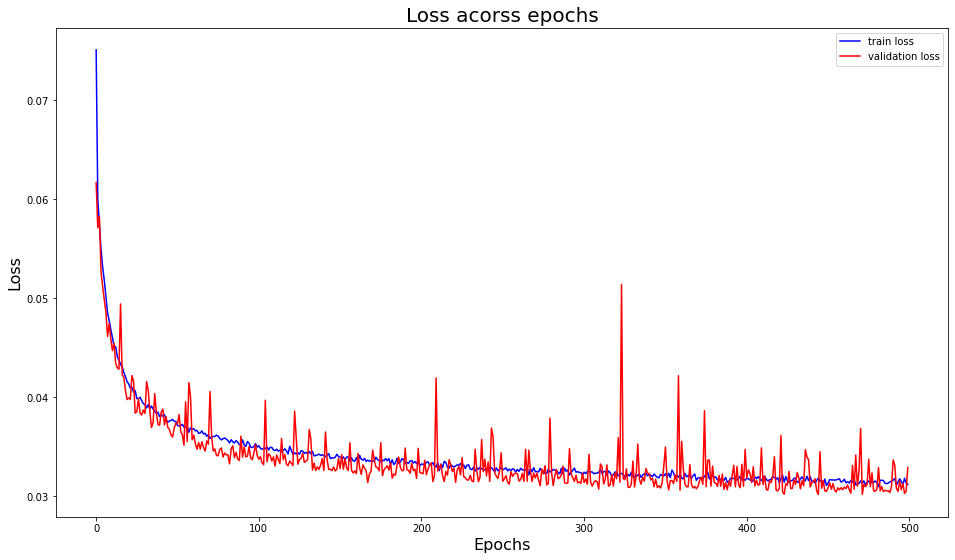

In [572]:
start_date = "2020-03-01"
end_date = "2020-10-01"

X,y = Generate_Period_Data(df_merge,start_date,end_date, minimum_case=10)
X_train, X_train_std, X_train_info,y_train,X_test, X_test_std, X_test_info,y_test = Split_Dataset(X,y,directory=f"./weights/scaler_{start_date}_{end_date}.pkl")
MLP,history = Train_NN(X_train_std,y_train,X_test_std.iloc[:-1],y_test.iloc[:-1],verbose=1,directory=f"./weights/NN_{start_date}_{end_date}")
Print_R2(history)



# DecisionTree(X_train_std,y_train,X_test_std,y_test,30)
# DecisionTreeMultiple(X_train_std,y_train,X_test_std,y_test,[10,20,30,40,50])
# RandomForest(X_train_std,y_train,X_test_std,y_test,50)
# Adaboost(X_train_std,y_train,X_test_std,y_test,50)
# KNNRegression(X_train_std,y_train,X_test_std,y_test)

Text(0, 0.5, 'log(growRate)')

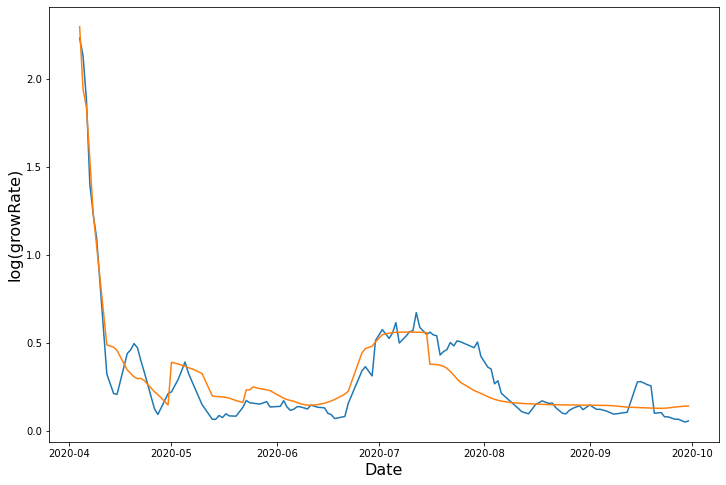

In [575]:
# ===== ===== ===== ===== =====
# Display y_true and y_pred

fip = 1015

Train_display = X_train.copy()
Train_display['y_true'] = y_train
Train_display['y_pred'] = train_pred
Train_display['fips'] = X_train_info['fips']
Train_display['date'] = X_train_info['date']
Train_display = Train_display[Train_display['fips']==fip]


plt.figure(figsize=(12,8))
sns.lineplot(x=Train_display['date'],y=Train_display['y_true']*10,data=Train_display)
sns.lineplot(x=Train_display['date'],y=Train_display['y_pred'],data=Train_display)
plt.title(f"County {fip} actual data and predicted value", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.xticks(rotation=0)
plt.ylabel("log(growRate)", fontsize=16)


<a id="Q2.4"></a>
## 2.4 Prediction
[▲ Return to contents](#Contents)

### 2.4.1 Parameter Setting Instructions

The parameters set here are default values for the county you are aiming at including socio-demographics and events. You can change them at any given date by specifying them. Those parameters are to predict everydays' log growth rate.



In [695]:
# Please specify the function to use:
#    0: Complete virtual scenario
#    1: Based on the county
function_index = 1
fips = 1009

# If choosing the function based on the county, please specify whether changing events date
implement_event = 1

# Please specify the start date for the simulation. We assume the cumulated confirmed cases is 10. Usually it varies between 2020-03-01~2020-04-01
start_date = "2020-03-01"

# Please specify the end date for the simulation. Please limit the date between start_date~"2020-09-30"
end_date = "2020-09-30"

# Specify the start date of the events
Event = {"George_Floyd":"2020-05-25",
         "policy_home":"2020-03-15",
         "policy_school":"2020-03-15",
         "policy_business":"2020-03-15",
         "policy_restaurant":"2020-03-15",
         "policy_facemask":"2020-03-15",
         "policy_gym":"2020-03-15",
         "policy_theater":"2020-03-15",
         "policy_bar":"2020-03-15"}

f_data = {}
# f_data['demo_vote_share'] = 0.99

feature_data = {}
feature_data['fips'] = 0
feature_data['date'] = ""
feature_data['cases_7'] = 0
feature_data['median_age_2017'] = 68.5
feature_data['population_2017'] = 1595192
feature_data['female_percentage_2017'] = 51.124
feature_data['Race_Hispanic'] = 7.7
feature_data['Race_White'] = 46.3
feature_data['Race_Black'] = 30.8
feature_data['Race_Native'] = 0.1
feature_data['Race_Asian'] = 11.2
feature_data['Race_Pacific'] = 100 - feature_data['Race_White'] - feature_data['Race_Asian'] - feature_data['Race_Native'] - feature_data['Race_Black'] - feature_data['Race_Hispanic']
feature_data['IncomePerCap'] = 47616
feature_data['IncomePerCapErr'] = 380
feature_data['WorkType_Professional'] = 55
feature_data['WorkType_Service'] = 14.3
feature_data['WorkType_Office'] = 19.1
feature_data['WorkType_Construction'] = 5.3
feature_data['WorkType_Production'] = 100 - feature_data['WorkType_Professional'] - feature_data['WorkType_Service'] - feature_data['WorkType_Office'] - feature_data['WorkType_Construction']
feature_data['Transp_Drive'] = 68.1
feature_data['Transp_Carpool'] = 6.9
feature_data['Transp_Transit'] = 12.1
feature_data['Transp_Walk'] = 5
feature_data['Transp_OtherTransp'] = 2.4
feature_data['Transp_WorkAtHome'] = 100 - feature_data['Transp_Carpool'] - feature_data['Transp_Transit'] - feature_data['Transp_Walk'] - feature_data['Transp_OtherTransp'] - feature_data['Transp_Drive']
feature_data['MeanCommute'] = 30.3
feature_data['Employed'] = 862873 
feature_data['Work_PrivateWork'] = 82.9
feature_data['Work_PublicWork'] = 10.7
feature_data['Work_SelfEmployed'] = 6.2
feature_data['Work_FamilyWork'] = 0.1
feature_data['Work_Unemployment'] = 100 - feature_data['Work_PrivateWork'] - feature_data['Work_PublicWork'] - feature_data['Work_SelfEmployed'] - feature_data['Work_FamilyWork']
feature_data['crime_rate_per_100000'] = 211.295
feature_data['demo_vote_share'] = 0.334
feature_data['lat'] = 42.4861
feature_data['long'] = -71.3905
feature_data['day_index'] = 0
feature_data['George_Floyd'] = 0
feature_data['policy_home'] = 0
feature_data['policy_school'] = 0
feature_data['policy_business'] = 0
feature_data['policy_restaurant'] = 0
feature_data['policy_facemask'] = 0
feature_data['policy_gym'] = 0
feature_data['policy_theater'] = 0
feature_data['policy_bar'] = 0
                                                                                                 
assert feature_data['Race_White']>=0
assert feature_data['WorkType_Production']>=0
assert feature_data['Transp_Drive']>=0
assert feature_data['Work_Unemployment']>=0

### 2.4.2 Construct the feed in data

Here we construct the time series data for the county.

In [696]:
def date2Timestamp(p_date):
    mTime = time.strptime(p_date,"%Y-%m-%d")
    otherStyleTime = int(time.mktime(mTime))
    return otherStyleTime
def timestamp2Date(timestamp):
    timeArray = time.localtime(timestamp)
    otherStyleTime = time.strftime("%Y-%m-%d", timeArray)
    return otherStyleTime
def getDates(start,end):
    start = date2Timestamp(start)
    end = date2Timestamp(end)
    
    dateList = []
    while(start<=end):
        date = timestamp2Date(start)
        dateList.append(date)
        start += 86400
        pass
    return dateList

#### 2.4.2a Method One: Pure virtual county

In [4]:
if function_index == 0:
    mDateList = getDates(start_date,end_date)
    mData = []
    for index, date in enumerate(mDateList):
        temp = feature_data.copy()
        temp['date'] = str(date)
        temp['day_index'] = index

        for event in Event:
            if date>=Event[event]:
                temp[event] = 1
                pass
            pass
        mData.append(temp)
        pass
    mData = pd.DataFrame(mData)
    mData['date'] = pd.to_datetime(mData['date'])
# mData_x = mData.drop(columns=['fips','date','cases_7'])
# mData_y = mData[['fips','date','cases_7']]
# print(mData['date'])

#### 2.4.2b Method Two: Existing county 

In [699]:
if function_index == 1:
    df = pd.read_csv("../../../02_Data/01_COVID/merged_case.csv",index_col=0)
    df = df.drop(columns=['delta_case'])
    df_county = df[df['fips']==fips]
    print(df_county.iloc[0])
    if implement_event == 0:
        mDateList = df_county.to_dict("records")
        pass
    else:
        mDateList = df_county.to_dict("records")
        for index, date in enumerate(mDateList):
            for event in Event:
                if date['date']>=Event[event]:
                    date[event] = 1
                else:
                    date[event] = 0
                    pass
                pass
            pass
    mData = pd.DataFrame(mDateList)
    mData['date'] = pd.to_datetime(mData['date'])
    mData = mData[(mData['date']>=start_date)&(mData['date']<=end_date)]
    for f in f_data:
        mData[f] = f_data[f]
        pass
    
    df_y = pd.read_csv("../../../02_Data/01_COVID/_7_day_average.csv",index_col=0)
    df_y = df_y[(df_y['fips']==fips)&(df_y['date']>=start_date)&(df_y['date']<=end_date)]
    df_y['date'] = pd.to_datetime(df_y['date'])

### 2.4.3 Process

In [700]:
def Load_Model(directory):
    model = joblib.load("./weights/"+directory)
    return model
def Load_NN(directory):
    MLP = keras.models.load_model(directory,compile=False)
    MLP.compile(optimizer=optimizers.Adam(lr=0.005),loss='mean_squared_error',metrics=[keras_r2])
    return MLP
def keras_r2(y_true,y_pred):
    y_mean=K.mean(y_true)
    # ssreg=K.sum((y_pred-y_mean)**2)
    sstotal=K.sum((y_true-y_mean)**2) # denominator
    ssres=K.sum((y_true-y_pred)**2)  # numerator
    score = 1-(ssres/sstotal)
    return score

In [7]:
# Period = ["2020-03-01","2020-05-01","2020-06-01","2020-07-01","2020-08-01","2020-09-01","2020-10-01"]
Period = ["2020-03-01","2020-10-01"]
Predicted_results = []
for index,p in enumerate(Period):
    print(f"Processing {p}")
    if p == "2020-10-01":
        continue
    mData_period = mData[(mData['date']>=p)&(mData['date']<Period[index+1])]
    if mData_period.shape[0]>0:
        dir_path = f"./weights/scaler_{Period[index]}_{Period[index+1]}.pkl"
        model_path = f"./weights/NN_{Period[index]}_{Period[index+1]}"
        with open(dir_path,'rb') as f:
            scaler = pickle.load(f)
        MLP = Load_NN(model_path)
#         MLP = Load_Model("RandomForest")
        
        mData_info = mData_period[['fips','date','cases_7']]
        mData_x = mData_period.drop(columns=['fips','date','cases_7'])
        columns = mData_x.columns
        mData_std = mData_x
        mData_std[columns] = scaler.transform(mData_x[columns])
        
        predicted = MLP.predict(mData_std)
        predicted = list(predicted.reshape((-1,))/10)
        Predicted_results = Predicted_results + predicted
        pass
    else:
        continue

Processing 2020-03-01
Processing 2020-10-01


In [8]:
mData['Result'] = Predicted_results
mData['Cumulative_Case'] = 0
mData['NewConfirmed_Case'] = 0
mData_list = mData.to_dict("records")
for index, row in enumerate(mData_list):
    if index == 0:
        row['Cumulative_Case'] = 10
        continue
    row['Cumulative_Case'] = np.exp(row['Result'] + np.log(mData_list[index-1]['Cumulative_Case']))
    row['NewConfirmed_Case'] = row['Cumulative_Case'] - mData_list[index-1]['Cumulative_Case']
    pass
Predicted = pd.DataFrame(mData_list)

<a id="Q2.5"></a>
## 2.5 Result Display
[▲ Return to contents](#Contents)

Text(0.5, 1.0, 'Cumulated Confirmed Cases')

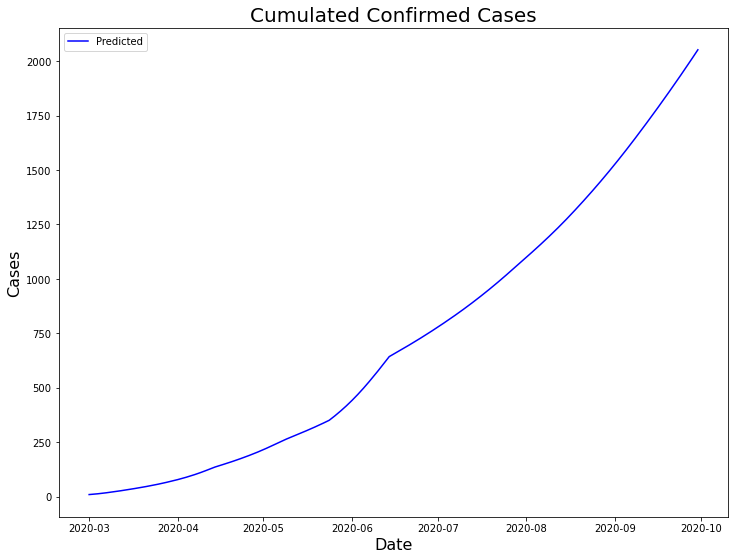

In [10]:
plt.figure(figsize=(12,9))
plt.plot(pd.to_datetime(Predicted['date']),Predicted['Cumulative_Case'],"b",label="Predicted")
if (function_index == 1):
    plt.plot(df_y['date'],df_y['cases_7'],"r",label="Actual 7-day moving average")

plt.xlabel("Date", fontsize=16)
plt.ylabel("Cases", fontsize=16)
plt.legend()
plt.title("Cumulated Confirmed Cases",fontsize=20)

<a id="Q2.6"></a>
## 2.6 Counterfactual simulations
[▲ Return to contents](#Contents)

The above models make it possible to tell us the growth of COVID-19 in any given scenario. The previous figures have provided us that the trained model could accurately predict the cases with actual data. Now, it is time to answer the question we proposed before: what if the policies implemented earlier or what if there isn’t any policy? The construction of counterfactual scenarios will be split into two parts which are a small change to the existing county and a complete virtual county.



#### Read result data to visualize

In [657]:
df_Scenario1 = pd.read_csv("../../../02_Data/08_Scenario/policy and george floyd.csv",index_col=0)
df_Scenario2 = pd.read_csv("../../../02_Data/08_Scenario/Implement Policy in Different Month.csv",index_col=0)

### 2.6.1 Scenario1: Policy & George Floyd event 

We evaluate the performance of both models with four settings: implementing the policy at the very beginning and there is no George Floyd event (PNF); implementing the policy at the very beginning and George Floyd event (PF); there isn’t any policy or George Floyd event (NPNF); there isn’t any policy but George Floyd event happened (NPF). 

The model shows us, if there is no policy to control the situation, the infected cases could be ten times of the current cases. 


Text(0.5, 1.0, 'Comparison of counterfactual scenarios')

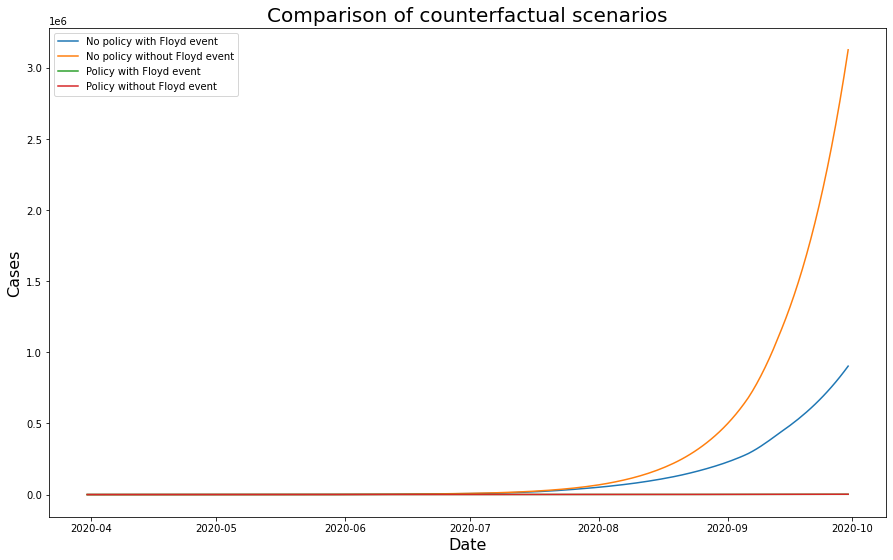

In [704]:
plt.figure(figsize=(15,9))
plt.plot(pd.to_datetime(df_Scenario1['Date']),df_Scenario1['Predicted_Cumulative_NPF'],label="No policy with Floyd event")
plt.plot(pd.to_datetime(df_Scenario1['Date']),df_Scenario1['Predicted_Cumulative_NPNF'],label="No policy without Floyd event")
plt.plot(pd.to_datetime(df_Scenario1['Date']),df_Scenario1['Predicted_Cumulative_PF'],label="Policy with Floyd event")
plt.plot(pd.to_datetime(df_Scenario1['Date']),df_Scenario1['Predicted_Cumulative_PNF'],label="Policy without Floyd event")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Cases", fontsize=16)
plt.legend()
plt.title("Comparison of counterfactual scenarios",fontsize=20)

### 2.6.2 Scenario2: Different time point to implement policies

Text(0.5, 1.0, 'Comparison of the time point to implement policies')

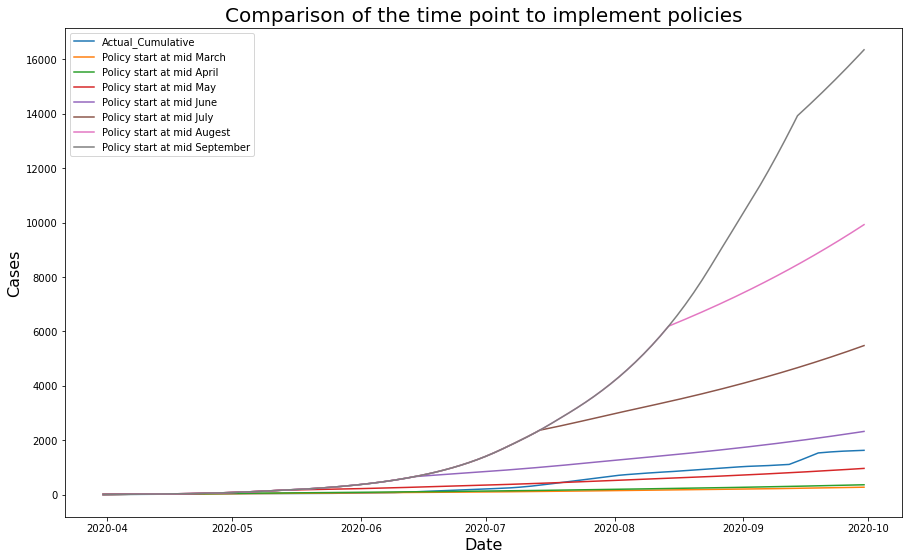

In [661]:
plt.figure(figsize=(15,9))
plt.plot(pd.to_datetime(df_Scenario2['Date']),df_Scenario2['Actual_Cumulative'],label="Actual_Cumulative")
plt.plot(pd.to_datetime(df_Scenario2['Date']),df_Scenario2['Predicted_Cumulative_Month3'],label="Policy start at mid March")
plt.plot(pd.to_datetime(df_Scenario2['Date']),df_Scenario2['Predicted_Cumulative_Month4'],label="Policy start at mid April")
plt.plot(pd.to_datetime(df_Scenario2['Date']),df_Scenario2['Predicted_Cumulative_Month5'],label="Policy start at mid May")
plt.plot(pd.to_datetime(df_Scenario2['Date']),df_Scenario2['Predicted_Cumulative_Month6'],label="Policy start at mid June")
plt.plot(pd.to_datetime(df_Scenario2['Date']),df_Scenario2['Predicted_Cumulative_Month7'],label="Policy start at mid July")
plt.plot(pd.to_datetime(df_Scenario2['Date']),df_Scenario2['Predicted_Cumulative_Month8'],label="Policy start at mid Augest")
plt.plot(pd.to_datetime(df_Scenario2['Date']),df_Scenario2['Predicted_Cumulative_Month9'],label="Policy start at mid September")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Cases", fontsize=16)
plt.legend()
plt.title("Comparison of the time point to implement policies",fontsize=20)

<a id="Q3"></a>
# 3. Re-opening and second wave
[▲ Return to contents](#Contents)

<a id="Q3.1"></a>
## 3.1 Define second wave
[▲ Return to contents](#Contents)

Eyeballing approach.

Method 1: look at the trend of the total cases in US.

In [124]:
# calculate new cases 
df_case['new_cases']=df_case['cases'].groupby(df_case['fips']).diff().fillna(0)
df_case['new_cases']=df_case['new_cases'].clip(lower=0)
    ## Calculate 7-day moving average
df_case['cases_7day_ave'] = df_case.groupby('fips', as_index=False)['new_cases'].rolling(window=7,center=True).mean().fillna(0).reset_index(
    0, drop=True)

# calculate total new covid cases in US
us_total=df_case.groupby('date', as_index=False).agg({"cases_7day_ave":"sum"})

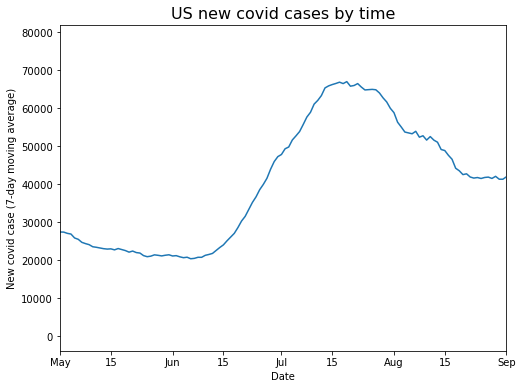

In [125]:
us_total['date']=pd.to_datetime(us_total['date'])

plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="cases_7day_ave",
             data=us_total)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(pd.to_datetime("2020-05-01"),pd.to_datetime("2020-09-01"))
g.set_xlabel('Date')
g.set_ylabel('New covid case (7-day moving average)')
plt.title("US new covid cases by time",fontsize=16)
plt.show()

Method 2: look at the case growth rate.

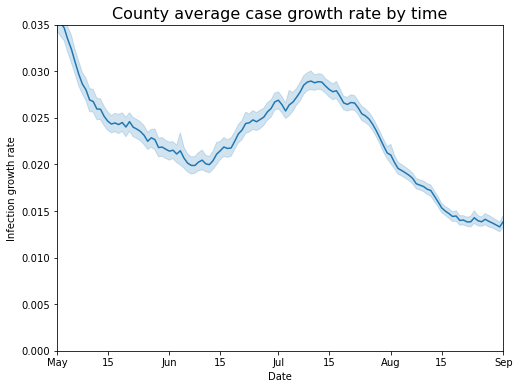

In [152]:
# case growth rate
df_case_delta = df_case_delta[(df_case_delta['cases_7']>=10)&(df_case_delta['date']>="2020-03-01")&(df_case_delta['delta_case']>0)]
df_case_delta.dropna(inplace=True)

plt.figure(figsize=(8,6))
g=sns.lineplot(x="date", y="delta_case",
             data=df_case_delta)
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator,formats=["","%b", '%d', '%H:%M', '%H:%M', '%S.%f'],show_offset=False)
g.xaxis.set_major_locator(locator)
g.xaxis.set_major_formatter(formatter)
g.set_xlim(pd.to_datetime("2020-05-01"),pd.to_datetime("2020-09-01"))
g.set_ylim(0,0.035)
g.set_xlabel('Date')
g.set_ylabel('Infection growth rate')
plt.title("County average case growth rate by time",fontsize=16)
plt.show()

Given the trend shown in these two figures, we define the beginning of second wave as June 15, and use the mobility data between May 15 to June 15 to predict the average COVID case growth June 15 - July 15 in each county.

<a id="Q3.2"></a>
## 3.2 Prepare predictors
[▲ Return to contents](#Contents)

Different from previous time series prediction, we prepare a cross-sectional database in which the socio-demographics, reopening time, and the average mobility in the month before the second wave are used to predict the average case growth (high/ low) in the beginning of second wave (June 15-July 14). We thus need to re-process some of the data to prepare for the predictions.

Specific steps:
<br> (1) Re-open early: 0-1, if stop stay-at-home order before May 15 defines as 1.
<br>(2) Face mask wearing habit: continuous score. Assign score 1 to 5 for "never" to "always" and calculate the score for each county. 
<br> (3) Socio-demographic characteristics of the county
<br> (4) Mobility by places May 15- Jun 15

### 3.2.1 Re-open time

In [210]:
# reopen time
    ## set Mar 15 as day 0 and get the reopening time for each place
df_policy = df_policy_og.copy()
df_policy['reopen_early']=[1 if pd.to_datetime(x)<pd.to_datetime('2020-05-15')
                        else 0 for x in df_policy['end_stay_at_home']]

df_policy['reopen_home']=(df_policy['end_stay_at_home'].astype('datetime64[ns]')-datetime.strptime('2020-03-15',"%Y-%m-%d")).dt.days
df_policy['reopen_home']=df_policy['reopen_home'].fillna(0)
df_policy['facemask']=(df_policy['facemask'].astype('datetime64[ns]')-datetime.strptime('2020-03-15',"%Y-%m-%d")).dt.days
df_policy['facemask']=df_policy['facemask'].fillna(0)

reopen_list=df_policy.columns.values[13:18]
for pol in reopen_list:
    df_policy[pol]=(df_policy[pol].astype('datetime64[ns]')-datetime.strptime('2020-03-15',"%Y-%m-%d")).dt.days
    df_policy[pol]=df_policy[pol].fillna(0)
    
df_policy=df_policy.drop(['state_fips','emergency','stay_at_home','gathering','end_stay_at_home',
               'close_school','close_nonessential_business','close_restaurant','close_gym',
               'close_theater','close_bar'],axis=1)

# ===== ===== ===== ===== =====
# Processed Data
# Output: df_policy

### 3.2.2 Average case growth in second wave (Jun 15 to Jul 15)

In [225]:
# df_case_delta=df_case_delta_og.copy()
df_case_delta = Seven_Day_Moving_Average(df_case,minimum_case=5)
df_case_delta = df_case_delta[(df_case_delta['cases_7']>=10)&(df_case_delta['date']>="2020-03-01")&(df_case_delta['delta_case']>0)]
df_case_delta.dropna(inplace=True)

# average case growth Jun 15 to Jul 15
df_case_secondwave=df_case_delta[(df_case_delta['date']>="2020-06-15")&(df_case_delta['date']<="2020-07-15")]
df_casegrowth=df_case_secondwave.groupby('fips', as_index=False).agg({"delta_case":"mean"})

# put quartile as predictors
df_casegrowth['quar_case']=pd.qcut(df_casegrowth['delta_case'],2, labels=["low", "high"])
df_casegrowth['high_case']=1*(df_casegrowth['quar_case']=="high")
df_casegrowth=df_casegrowth.drop(columns=['quar_case'],axis=1)

# ===== ===== ===== ===== =====
# Processed Data
# Output: df_casegrowth

100%|█████████████████████████████████████████████████████████████████████████████| 3241/3241 [00:21<00:00, 150.70it/s]


### 3.2.3 Average mobility in the month before second wave

In [217]:
## impute missing data. Since workplace mobility is more complete, we will use this column to impute the others. (based on MAR imputation)
missing_list=df_mob.columns.values[7:13]
for col in missing_list:
    ols_imputer_mar=LinearRegression().fit(df_mob.dropna(axis=0,subset=['workplaces_percent_change_from_baseline',col])[['workplaces_percent_change_from_baseline']],
                                           df_mob.dropna(axis=0,subset=['workplaces_percent_change_from_baseline',col])[col])    
    x1hat_impute = pd.Series(ols_imputer_mar.predict(df_mob[['workplaces_percent_change_from_baseline']].dropna()))
    df_mob[col] = df_mob[col].fillna(x1hat_impute)
    
## keep county-level data
df_mob_county=df_mob.dropna(axis=0,subset=["sub_region_2"])
df_mob_county=df_mob_county.drop(columns=['country_region_code','country_region','metro_area','iso_3166_2_code'])
df_mob_county=df_mob_county.rename(columns={'sub_region_1':'state','sub_region_2':'county'})
df_mob_county.head()

## calculate average mobility May 15 to Jun 14
df_mob_county=df_mob_county[(df_mob_county['date']>="2020-05-15")&(df_mob_county['date']<"2020-06-15")]
df_mob_county=df_mob_county.groupby(['state','county'], as_index=False).agg(["mean"]).reset_index()
df_mob_county.columns = df_mob_county.columns.droplevel(1)

# ===== ===== ===== ===== =====
# Processed Data
# Output: df_mob_county

### 3.2.4 Merge data

In [218]:
df_sd=df_sd_og.copy()

df_sd.loc[549,'ChildPoverty'] = df_sd[df_sd["state"]=="Hawaii"]["ChildPoverty"].median()
df_missing_crime = df_sd[df_sd["crime_rate_per_100000"].isnull()]
df_missing_crime_num = df_missing_crime.groupby("state")["state"].count()

crime_columns = ["crime_rate_per_100000","IDNO","Crime_CPOPARST","Crime_CPOPCRIM","Crime_AG_OFF","Crime_COVIND","Crime_MODINDX","Crime_MURDER","Crime_RAPE","Crime_ROBBERY","Crime_AGASSLT","Crime_BURGLRY","Crime_LARCENY","Crime_MVTHEFT","Crime_ARSON"]
state_list = ["Alaska","New Mexico","South Dakota"]
for state in state_list:
    index_list = df_missing_crime[df_missing_crime['state']==state]["index"].tolist()
    for crime in crime_columns:
        for index in index_list:
            df_sd.loc[index-1,crime] = df_sd[df_sd['state']==state][crime].median()

In [226]:
# merge the data
    ## socio-demographic
df_merge=df_sd.copy()
    ## add case growth (Jun 15- Jul 15)
df_merge=df_merge.merge(df_casegrowth, on=['fips'],how='left')
    ## add mobility
df_merge=df_merge.merge(df_mob_county, on=['state','county'],how='left')
    ## add face mask
df_merge=df_merge.merge(df_facemask, on=['fips'],how='left')
    ## add reopen time
df_merge=df_merge.merge(df_policy, on=['state','state_code'],how='left')
#     ## weather
# df_merge=df_merge.merge(df_weather_sub, on=['fips'],how='left')

# ===== ===== ===== ===== =====
# Merge Data
# Output: df_merge

### 3.2.5 Split and standardization

In [227]:
df_complete=df_merge.drop([ 'state_code','lat', 'long','IDNO','Income', 'IncomeErr', 'reopen_early'],axis=1).dropna()
# split train-test data
df_train, df_test, = train_test_split(
    df_complete, test_size=0.2,  random_state = 121, shuffle=True
)
X_train=df_train.drop(['fips', 'county', 'state', 'democrat','delta_case', 'high_case','facemask_score'],axis=1)
X_test=df_test.drop(['fips', 'county', 'state', 'democrat','delta_case', 'high_case','facemask_score'],axis=1)
y_train=df_train['high_case']
y_test=df_test['high_case']

# standardized
scaler = StandardScaler().fit(X_train)
X_train_std = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [228]:
print(df_complete.shape,df_merge.shape)

(2531, 74) (3220, 81)


<a id="Q3.3"></a>
## 3.3 Train models and prediction
[▲ Return to contents](#Contents)

We will predict the average case growth rate at the beginning of the second wave in US (Jun 15- July 15) using the county socio-demographics, county political ideology, county reopening time by places, county mobility by places in the previous month, and county facemask wearing rate. Instead of using continuous growth rate, our response variable is the below/ above median of growth rate. Thus we will classify counties into two classes. 

This section will proceed in six steps: 
<br> (1) Simple logistic regression model;
<br> (2) Lasso penalized logistic regression model;
<br> (3) Logistic regression after PCA;
<br> (4) Random Forest classification model; 
<br> (5) Boosting.
<br> (6) ANN classification model. 

### 3.3.1 Model-1: Logistic regression
(1) Simple logistic regression; 
<br> (2) Lasso regularized; 
<br> (3) PCA.

#### 3.3.1a Model-1(1): Simple logistic regression

In [229]:
warnings.simplefilter("ignore")

In [230]:
logit_basic=LogisticRegression(penalty="none", solver='lbfgs', max_iter = 5000)
logit_basic.fit(X_train,y_train)

logit_basic_train_accuracy = logit_basic.score(X_train_std,y_train)
logit_basic_test_accuracy = logit_basic.score(X_test_std,y_test)

print("The training and testing classification accuracies are:",logit_basic_train_accuracy.round(4),logit_basic_test_accuracy.round(4))

The training and testing classification accuracies are: 0.6502 0.6529


#### 3.3.1b Model-1(2): LASSO

In [231]:
Cs = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]
cv = 3
penalty = 'l1'
solver = 'liblinear'

t1 = timeit.default_timer()

lasso_regr = LogisticRegressionCV(
    Cs=Cs, cv=cv, penalty=penalty, solver=solver,max_iter = 5000
).fit(X_train_std, y_train)

# accuracy
train_score_lasso = lasso_regr.score(X_train_std, y_train)
test_score_lasso = lasso_regr.score(X_test_std, y_test)

train_time = timeit.default_timer() - t1

print(f'The training and testing classification accuracies are: {train_score_lasso: .4f} and {test_score_lasso: .4f}')
print(f'Best regularization parameter {lasso_regr.C_[0]: .4f}')
print(f'Model training time {train_time: .4f}')

The training and testing classification accuracies are:  0.7045 and  0.6805
Best regularization parameter  0.1000
Model training time  31.3356


In [350]:
print(str(np.sum(lasso_regr.coef_==0)) + ' predictors are considered unimportant')
print(f'{np.sum(lasso_regr.coef_!=0)} predictors are considered important in the regularized model')

df_lasso_coef=pd.DataFrame({'var': list(X_train.columns.values), 'lasso_coef': list(lasso_regr.coef_[0])}, columns=['var', 'lasso_coef'])
df_lasso_coef['coef_abs']=df_lasso_coef['lasso_coef'].abs()
df_lasso_coef=df_lasso_coef.sort_values(by='coef_abs', ascending=False)
df_lasso_coef[['var','lasso_coef']].head(5)

26 predictors are considered unimportant
41 predictors are considered important in the regularized model


,var,lasso_coef
48,demo_vote_share,-0.399442
4,Race_Hispanic,0.364393
60,reopen_business,-0.288938
51,parks_percent_change_from_baseline,-0.283702
54,residential_percent_change_from_baseline,-0.275326


Three insights from the results:
<br> (1) Political ideology is the largest predictor for second wave case growth, with the higher share of voters for democrats the lower probability to have high case growth;
<br> (2) Late reopen of business and theater decrease the chances of a county to have high case growth in the second wave;
<br> (3) Mobility is another important factor, with higher mobility at parks and residential places correlated with lower case growth.

#### 3.3.1c Model-1(3): PCA 

Since there are still many variables considered as important, we can try using PCA to further reduce the dimensions.

Top 2 PCA variance explained:  0.344
number of components that explain at least 90% of the variance= 29


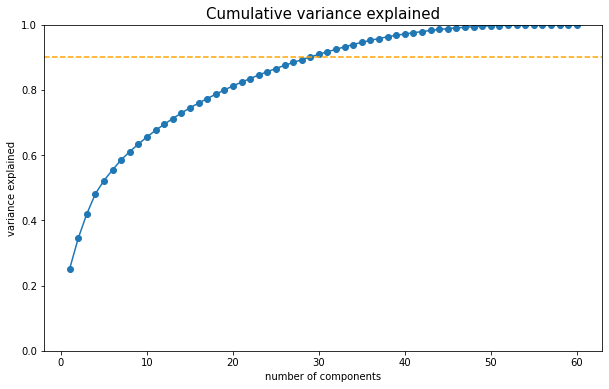

In [236]:
pca = PCA().fit(X_train_std)
pca_xtrain = pca.transform(X_train_std)
pca_xtest = pca.transform(X_test_std)

print( f'Top 2 PCA variance explained: {np.sum(pca.explained_variance_ratio_[0:2]): .3f}')

var_explained = []
total_comp = 60
pca = PCA(n_components = total_comp).fit(X_train_std)

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(range(1, total_comp+1), np.cumsum(pca.explained_variance_ratio_), 'o-')
ax.axhline(0.90, linestyle='--', color='orange')
ax.set_ylim(0,1)
ax.set_xlabel('number of components')
ax.set_ylabel('variance explained')
ax.set_title('Cumulative variance explained',fontsize=15)

print("number of components that explain at least 90% of the variance=",\
    len(np.where(np.cumsum(pca.explained_variance_ratio_)<0.90)[0])+1)

In [243]:
component=29
pca = PCA(n_components = component).fit(X_train_std)  
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
    
logreg_pca = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000)
logreg_pca.fit(X_train_pca, y_train)

y_train_pred_logreg_pca = logreg_pca.predict(X_train_pca)
y_test_pred_logreg_pca = logreg_pca.predict(X_test_pca)
train_score = accuracy_score(y_train, y_train_pred_logreg_pca)
test_score = accuracy_score(y_test, y_test_pred_logreg_pca)

print(f'The training and testing classification accuracies are: {train_score: .4f} and {test_score: .4f}')

The training and testing classification accuracies are:  0.6922 and  0.6824


### 3.3.2 Model-2: Decision Tree
(1) Random Forest; 
<br> (2) Boosting

#### 3.3.2a Model-2(1):  Random Forests

In [245]:
tree_depth=10
n_trees = 55 

fitted_rf = RandomForestClassifier(n_estimators=n_trees, max_features='sqrt', max_depth=tree_depth).fit(X_train_std,y_train)
random_forest_train_score = fitted_rf.score(X_train_std, y_train)
random_forest_test_score = fitted_rf.score(X_test_std, y_test)
print(f"The random forest scored {random_forest_train_score:.4f} on the train set.")
print(f"The random forest scored {random_forest_test_score:.4f} on the test set.")

The random forest scored 0.9704 on the train set.
The random forest scored 0.7219 on the test set.


In [248]:
top_predictors_rf = [X_train.columns[model.tree_.feature[0]]  for  model in fitted_rf.estimators_ ]
top_predictors_rf_df = pd.DataFrame(pd.Series(top_predictors_rf).value_counts(), columns=['Count'])
display(top_predictors_rf_df.head(5))


,Count
reopen_theater,9
reopen_gym,7
reopen_restaurant,5
facemask,4
demo_vote_share,4


#### 3.3.2b Model-2(2):  Boosting

In [250]:
dtrain = xgb.DMatrix(X_train_std, label=y_train)
dtest = xgb.DMatrix(X_test_std, label=y_test)

# Parameters
param = {
    'max_depth': 12,  # the maximum depth of each tree
    'eta': 0.3,               # the training step for each iteration
    'silent': 1,              # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}           # the number of classes that exist in this datset

# Number of training iterations
num_round = 200  

# Train XGBoost
bst = xgb.train(param, 
                dtrain, 
                num_round, 
                evals= [(dtrain, 'train')], 
                early_stopping_rounds=20, # early stopping
                verbose_eval=20)


# Make prediction training set
preds_train = bst.predict(dtrain)
best_preds_train = np.asarray([np.argmax(line) for line in preds_train])

# Make prediction test set
preds_test = bst.predict(dtest)
best_preds_test = np.asarray([np.argmax(line) for line in preds_test])

# Performance Evaluation 
acc_XGBoost_training = accuracy_score(y_train, best_preds_train)*100
acc_XGBoost_test = accuracy_score(y_test, best_preds_test)*100


print("XGBoost:\tAccuracy, Training Set \t: {:0.2f}%".format(acc_XGBoost_training))
print("XGBoost:\tAccuracy, Testing Set \t: {:0.2f}%".format(acc_XGBoost_test))

[20:43:34] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.07411
Will train until train-merror hasn't improved in 20 rounds.
[20]	train-merror:0.00000
Stopping. Best iteration:
[7]	train-merror:0.00000

XGBoost:	Accuracy, Training Set 	: 100.00%
XGBoost:	Accuracy, Testing Set 	: 71.60%


### 3.3.3 Model-3: Artificial Neural Networks


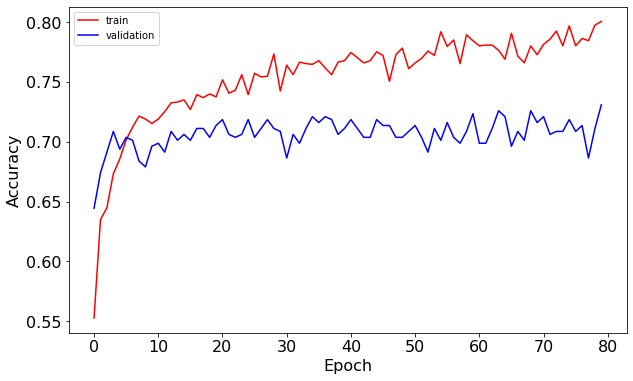

In [335]:
l2=0.01
dropout=0.25
lr=0.001
epochs=80
batch_size=16
node=25

l2=tf.keras.regularizers.l2(l2)
NN_model = tf.keras.models.Sequential()
NN_model.add(tf.keras.layers.Dense(node, activation='relu',
                        input_shape=(X_train_std.shape[1],),kernel_regularizer=l2,name='hidden-1'))
NN_model.add(tf.keras.layers.Dropout(dropout))
NN_model.add(tf.keras.layers.Dense(node, activation='relu',kernel_regularizer=l2,name='hidden-2'))
NN_model.add(tf.keras.layers.Dropout(dropout))
NN_model.add(tf.keras.layers.Dense(node, activation='relu',kernel_regularizer=l2,name='hidden-3'))
NN_model.add(tf.keras.layers.Dense(1, activation='sigmoid',kernel_regularizer=l2,name='output'))

optimizer=tf.keras.optimizers.Adam(lr)
NN_model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=optimizer)
NN_model_history=NN_model.fit(X_train_std,y_train,epochs=epochs,batch_size=batch_size,verbose=0,validation_split=0.2)
    
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(NN_model_history.history['accuracy'], 'r', label='train')
ax.plot(NN_model_history.history['val_accuracy'], 'b' ,label='validation')
ax.set_xlabel(r'Epoch', fontsize=16)
ax.set_ylabel(r'Accuracy', fontsize=16)
ax.legend()
ax.tick_params(labelsize=16)

In [336]:
NN_train_acc=NN_model.evaluate(X_train_std, y_train,verbose=0,batch_size=batch_size)[1]
NN_test_acc =NN_model.evaluate(X_test_std, y_test,verbose=0, batch_size=batch_size)[1]

print("The training and testing accuracies are", round(NN_train_acc,4), "and", round(NN_test_acc,4))

The training and testing accuracies are 0.8068 and 0.7219


#### Interpret Artificial Neural Networks model using different methods.

##### (1)Now we try to understand the implications of the results through proxying a logistic regression.

In [337]:
y_predict_train=NN_model.predict_classes(X_train_std).reshape(-1,)
y_predict_test=NN_model.predict_classes(X_test_std).reshape(-1,)

C=0.02
penalty='l2'
solver = 'lbfgs'

logreg=LogisticRegression(C=C,penalty=penalty,solver=solver).fit(X_train_std, y_predict_train)
logreg_train_acc = logreg.score(X_train_std, y_train)
logreg_test_acc = logreg.score(X_test_std, y_test)

print("The training and testing set accuracy are ",round(logreg_train_acc,4),"and ",round(logreg_test_acc,4))

The training and testing set accuracy are  0.712 and  0.7022


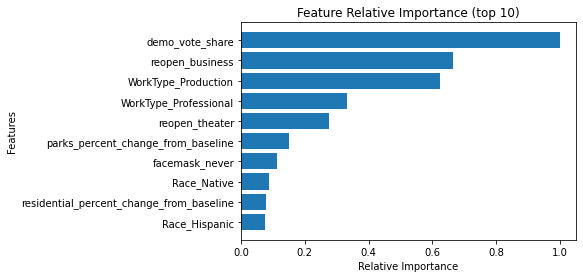

In [338]:
perm_result = permutation_importance(logreg, X_train_std, y_predict_train, n_jobs=-1)
features=X_train.columns.values
top_10=perm_result.importances_mean.argsort()[-10:]
top10_feature= features[top_10]
top10_rel_score=perm_result.importances_mean[top_10]/perm_result.importances_mean.max()

plt.barh(top10_feature, top10_rel_score)
plt.ylabel('Features')
plt.xlabel('Relative Importance')
plt.title('Feature Relative Importance (top 10)')
plt.show()

Again, we see political ideology and reopening of business, restuarant and theater ahead of the list in predicting the second wave, folloed by race and mobility at parks and home.

##### (2) We can also directly apply permutation importance calculating using Eli-5.

In [339]:
seed = 56
def aucscore(model, X, y):
    y_pred = model.predict(X)
    return roc_auc_score(y, y_pred)

aucscore(NN_model,X_train_std, y_train)
perm = PermutationImportance(NN_model, random_state=seed,n_iter=10, scoring=aucscore).fit(X_test_std,y_test)
eli5.show_weights(perm,feature_names=X_test_std.columns.tolist(),top=10)

Weight,Feature
0.0299 ± 0.0100,demo_vote_share
0.0209 ± 0.0109,Race_Hispanic
0.0195 ± 0.0056,residential_percent_change_from_baseline
0.0179 ± 0.0061,reopen_home
0.0154 ± 0.0100,reopen_theater
0.0117 ± 0.0083,MeanCommute
0.0096 ± 0.0131,parks_percent_change_from_baseline
0.0080 ± 0.0131,WorkType_Production
0.0078 ± 0.0067,retail_and_recreation_percent_change_from_baseline
0.0072 ± 0.0061,Poverty


As before, the most important predictors are political ideology, reopening policy,and mobility at residential areas & parks. Having these predictors being picked up by all the models reinforce our confidence that these are indeed the most crucial determinants for second wave.

<a id="Q3.4"></a>
## 3.4 Model interpretation
[▲ Return to contents](#Contents)

### 3.4.1 LIME (for random forest)

County #: 1687
High case growth probability = 0.05652199489256551
True class: 0.0


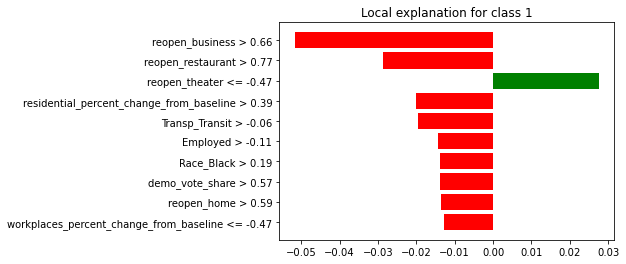

In [341]:
explainer = LimeTabularExplainer(X_train_std.values,
                                 feature_names=X_train_std.columns,
                                 class_names = [0,1],
                                 mode='classification')
# Select county of interests
    ## Queens County in New York
idx=int(np.where((df_train["county"]=='Queens County') & (df_train["state"]=='New York'))[0])

exp = explainer.explain_instance(X_train_std.values[idx], 
                                 fitted_rf.predict_proba, 
                                 num_features = 10)

print('County #: %d' % idx)
print('High case growth probability =', fitted_rf.predict_proba(X_train_std)[idx][1])
print('True class: %s' % y_train[idx])

exp.as_pyplot_figure();

Queens county in New York state generally reopened late, which makes it less susceptible to very severe second wave.

County #: 1750
High case growth probability = 0.8362524381278325
True class: 2698    1.0
Name: high_case, dtype: float64


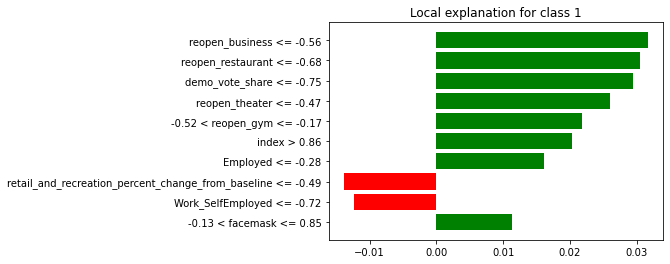

In [342]:
    ## Newton County in Texas
idx=int(np.where((df_train["county"]=='Newton County') & (df_train["state"]=='Texas'))[0])

exp = explainer.explain_instance(X_train_std.values[idx], 
                                 fitted_rf.predict_proba, 
                                 num_features = 10)

print('County #: %d' % idx)
print('High case growth probability =', fitted_rf.predict_proba(X_train_std)[idx][1])
print('True class: %s' % y_train[(df_train["county"]=='Newton County') & (df_train["state"]=='Texas')])

exp.as_pyplot_figure();

In contrast, the Newton County in Texas reopened early, which is a significant contributor to its high case growth. And for both cases, political ideology and mobility at park in the previous month also contribute to the prediction.

### 3.4.2 Global relationship between reopening and high case growth probability

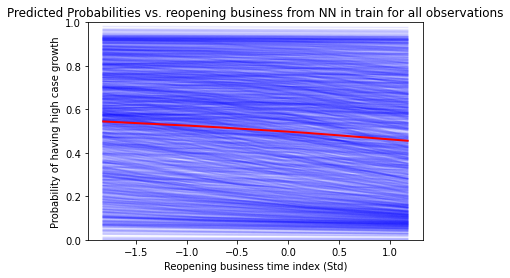

In [351]:
means1 = X_train_std.mean(axis = 0)
means_df = (means1.to_frame()).transpose()

# Do the prediction at all observed reopening times
reopen_home = np.arange(np.min(X_train_std['reopen_home']),np.max(X_train_std['reopen_home']))
means_df  = pd.concat([means_df]*reopen_home.size,ignore_index=True)
means_df['reopen_home'] = reopen_home

yhat_nns = []
for i in range(0,X_train_std.shape[0]):
    obs = X_train_std.iloc[i,:].to_frame().transpose()
    obs_df  = pd.concat([obs]*reopen_home.size,ignore_index=True)
    obs_df['reopen_business'] = reopen_home
    yhat_nn = NN_model.predict_proba(obs_df)
    yhat_nns.append(yhat_nn.transpose())
    plt.plot(obs_df['reopen_business'],yhat_nn,color='blue',alpha=0.05)

plt.plot(obs_df['reopen_business'],np.mean(yhat_nns,axis=0)[0],color='red',linewidth=2);
    
plt.ylim(0,1)
plt.ylabel("Probability of having high case growth")
plt.xlabel("Reopening business time index (Std)")
plt.title("Predicted Probabilities vs. reopening business from NN in train for all observations");

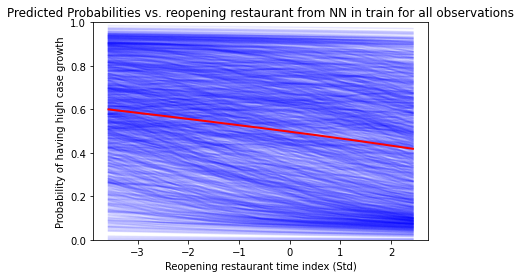

In [347]:
means1 = X_train_std.mean(axis = 0)
means_df = (means1.to_frame()).transpose()

reopen_restaurant = np.arange(np.min(X_train_std['reopen_restaurant']),np.max(X_train_std['reopen_restaurant']))
means_df  = pd.concat([means_df]*reopen_restaurant.size,ignore_index=True)
means_df['reopen_restaurant'] = reopen_restaurant

yhat_nns = []
for i in range(0,X_train_std.shape[0]):
    obs = X_train_std.iloc[i,:].to_frame().transpose()
    obs_df  = pd.concat([obs]*reopen_restaurant.size,ignore_index=True)
    obs_df['reopen_restaurant'] = reopen_restaurant
    yhat_nn = NN_model.predict_proba(obs_df)
    yhat_nns.append(yhat_nn.transpose())
    plt.plot(obs_df['reopen_restaurant'],yhat_nn,color='blue',alpha=0.05)

plt.plot(obs_df['reopen_restaurant'],np.mean(yhat_nns,axis=0)[0],color='red',linewidth=2);
    
plt.ylim(0,1)
plt.ylabel("Probability of having high case growth")
plt.xlabel("Reopening restaurant time index (Std)")
plt.title("Predicted Probabilities vs. reopening restaurant from NN in train for all observations");

<a id="Q4"></a>
# 4. Mobility & face mask policy
[▲ Return to contents](#Contents)

## 4.1 Prepare predictors

### 4.1.1 Clean the data

In [51]:
drop_index = (cases_df.loc[(cases_df['state'] == 'American Samoa') | (cases_df['state'] == 'Virgin Islands')]).index
cases_df = cases_df.drop(index = drop_index)
drop_index = (cases_df.loc[(cases_df['state'] == 'Diamond Princess') | (cases_df['state'] == 'Puerto Rico')]).index
cases_df = cases_df.drop(index = drop_index)
drop_index = (cases_df.loc[(cases_df['state'] == 'Northern Mariana Islands') | (cases_df['state'] == 'District of Columbia')]).index
cases_df = cases_df.drop(index = drop_index)
drop_index = (cases_df.loc[(cases_df['state'] == 'Grand Princess') | (cases_df['state'] == 'Guam')]).index
cases_df = cases_df.drop(index = drop_index)

### 4.1.2 Check & drop null columns

In [58]:
# check for null columns
null_columns = cases_df.columns[cases_df.isnull().any()]
cases_df[null_columns].isnull().sum()

# drop all null columns
cases_df = cases_df.dropna()
# cases_df.isnull().any()
# cases_df.loc[cases_df['state_code'].isnull()]

### 4.1.3 Merge the data

Let's join the dataframes by fips code, states, counties, date and facemask.

In [59]:
df = county_df.merge(cases_df, left_on=['census_fips_code', 'sub_region_1', 'sub_region_2', 'date'], right_on=['fips', 'state', 'county', 'date'])

# save all predictors in its own variable
predictors_list = ['retail_and_recreation', 'grocery_and_pharmacy', 'parks', 'transit_stations', 'workplaces', 'residential']

# add in the 7 day average for the cases and deaths
df['cases_7day_ave'] = df.groupby('fips', as_index=False)['cases'].rolling(window=7,center=True).mean().fillna(0).reset_index(0, drop=True)
df['deaths_7day_ave'] = df.groupby('fips', as_index=False)['deaths'].rolling(window=7,center=True).mean().fillna(0).reset_index(0, drop=True)

# do the same for the 6 predictors
for i in range(len(predictors_list)):
    df[f'{predictors_list[i]}_7day_ave'] = df.groupby('fips', as_index=False)[predictors_list[i]].rolling(window=7,center=True).mean().fillna(0).reset_index(0, drop=True)
    
# include facemask data
df = df.merge(df_facemask, on='fips')

# drop the lats and longs
df = df.drop(columns=['lat', 'long'])

### 4.1.4 Split between predictors and response variables

In [60]:
# split between predictors and response variables
X = df.drop(columns=['cases', 'deaths', 'cases_7day_ave', 'deaths_7day_ave'])
y = df[['cases', 'deaths', 'cases_7day_ave', 'deaths_7day_ave']]

In [61]:
# split between train and test data -- for covid deaths
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.3, random_state=111)
X_train, X_test, y_train, y_test = X_train_raw, X_test_raw, y_train_raw, y_test_raw
print(f"The shape of: \n"
      f"X_train is {X_train.shape}\n"
      f"X_test is {X_test.shape}\n"
      f"y_train is {y_train.shape}\n"
      f"y_test is {y_test.shape}\n")

The shape of: 
X_train is (7065, 26)
X_test is (3029, 26)
y_train is (7065, 4)
y_test is (3029, 4)



## 4.2 Explore the relationship between mobility predictors and cases

Check out the same but with 7-day average cases

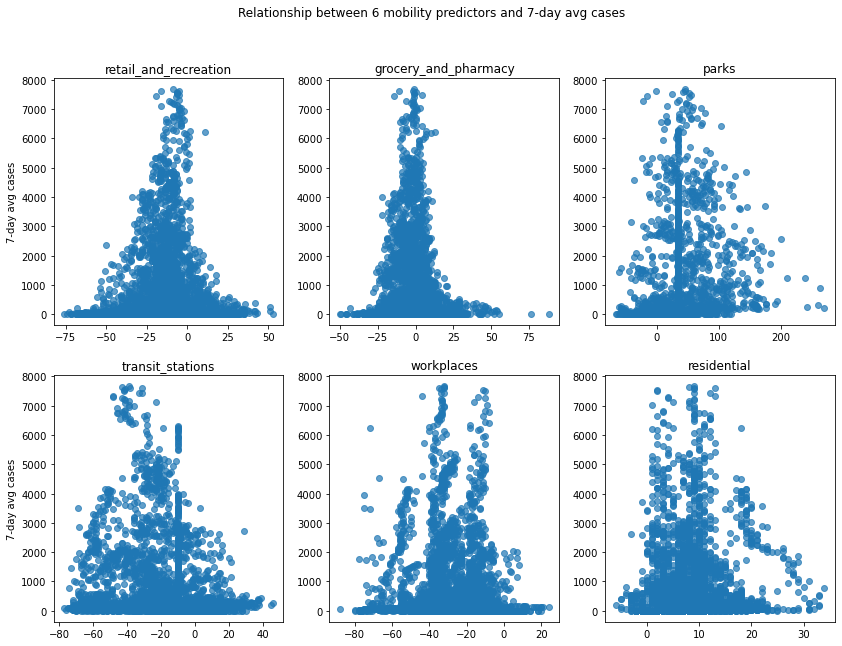

In [63]:
fig, axs = plt.subplots(2, 3, figsize=(14, 10))
fig.suptitle("Relationship between 6 mobility predictors and 7-day avg cases")
i = 0
for ax in axs.flat:
    ax.scatter(X_train[predictors_list[i]], y_train['cases_7day_ave'], alpha=0.7)
    ax.set_title(predictors_list[i])
    if i == 0 or i == 3:
        ax.set_ylabel("7-day avg cases")
    i += 1

## 4.3 Build models

### 4.3.1  Model-1: polynomial regression

In [77]:
# Use this function to calculate a polynomial regression, given a list of predictors
def polynomial_regression(y_var_train, y_var_test, list_of_predictors, verbose=True):
    poly = PolynomialFeatures(4)
    x_train = poly.fit_transform(X_train[list_of_predictors])

    # Train our model
    model = LinearRegression(fit_intercept=False) # intercept part of PolynomialFeatures!
    model.fit(x_train, y_var_train)

    # Test our model
    y_pred_train = model.predict(x_train)
    x_test = poly.fit_transform(X_test[list_of_predictors])
    y_pred_test = model.predict(x_test)

    # Calculate MSEs
    test_mse = mean_squared_error(y_var_test, y_pred_test)
    train_mse = mean_squared_error(y_var_train, y_pred_train)

    # Calculate r2
    test_r2 = r2_score(y_var_test, y_pred_test)
    train_r2 = r2_score(y_var_train, y_pred_train)
    
    # Go ahead and print what we want
    if verbose:
        print(f"The MSE is {train_mse} for train")
        print(f"r^2 is {train_r2} for train\n")
        print(f"The MSE is {test_mse} for test")
        print(f"r^2 is {test_r2} for test")

    # Just in case, return relevant information
    return train_mse, test_mse, train_r2, test_r2


### 4.3.2  Model-2: bagging regression

In [78]:
# Use this function to calculate a decision tree regression, given a list of predictors
def bagging_regression(y_var_train, y_var_test, list_of_predictors, verbose=True):
    num_bootstraps = 80
    max_depth = 65

    # Define the Bagging Regressor Model
    model = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=max_depth),n_estimators=num_bootstraps)

    # Fit the model on the train data
    model.fit(X_train[list_of_predictors], y_var_train)
    
    # Test our model
    y_pred_train = model.predict(X_train[list_of_predictors])
    y_pred_test = model.predict(X_test[list_of_predictors])
    
    # Calculate MSEs
    test_mse = mean_squared_error(y_var_test, y_pred_test)
    train_mse = mean_squared_error(y_var_train, y_pred_train)
    
    # Calculate r2
    test_r2 = r2_score(y_var_test, y_pred_test)
    train_r2 = r2_score(y_var_train, y_pred_train)

    # print predictions if verbose
    if verbose:
        print(f"The MSE is {train_mse} for train")
        print(f"r^2 is {train_r2} for train\n")
        print(f"The MSE is {test_mse} for test")
        print(f"r^2 is {test_r2} for test")
        
    # Just in case, return relevant information
    return train_mse, test_mse, train_r2, test_r2

## 4.4 Predictions

### 4.4.1 Predict cases on each of the 6 mobility predictors individually.

To reduce bias and avoid the zero value problem, we use smoothed 7-day moving average cases and mobility data to predict

In [79]:
predictors_list = ['retail_and_recreation_7day_ave', 'grocery_and_pharmacy_7day_ave', 'parks_7day_ave', 'transit_stations_7day_ave', 'workplaces_7day_ave', 'residential_7day_ave']

poly_mses_train = {}
poly_mses_test = {}

poly_r2_train = {}
poly_r2_test = {}

train_list_mse = []
test_list_mse = []

train_list_r2 = []
test_list_r2 = []

for i in range(6):
    
    train_mse, test_mse, train_r2, test_r2 = polynomial_regression(y_train['cases_7day_ave'], y_test['cases_7day_ave'], 
                                                                [predictors_list[i]], verbose=False)

    poly_mses_train.update([(predictors_list[i], train_mse)])
    poly_mses_test.update([(predictors_list[i], test_mse)])
    
    poly_r2_train.update([(predictors_list[i], train_r2)])
    poly_r2_test.update([(predictors_list[i], test_r2)])
    
    train_list_mse.append(train_mse)
    test_list_mse.append(test_mse)
    
    train_list_r2.append(train_r2)
    test_list_r2.append(test_r2)
    
poly_mses_train_df = pd.DataFrame(data=[poly_mses_train, poly_r2_train], index=['MSE', 'R2'])
poly_mses_test_df = pd.DataFrame(data=[poly_mses_test, poly_r2_test], index=['MSE', 'R2'])

print("Train set:")
display(poly_mses_train_df)

print("Test set:")
display(poly_mses_test_df)

print(f"The mean R2 for train set on all individual predictors is {poly_mses_train_df.loc['R2'].mean()}")
print(f"The mean R2 for test set on all individual predictors is {poly_mses_test_df.loc['R2'].mean()}")


Train set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,1.066769e+06,1.073750e+06,1.022717e+06,954568.205844,1.064826e+06,1.092562e+06
R2,4.903954e-02,4.281635e-02,8.830937e-02,0.149060,5.077180e-02,2.604673e-02


Test set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,1.066833e+06,1.076566e+06,1.060312e+06,942711.543031,1.065709e+06,1.096208e+06
R2,5.413261e-02,4.550304e-02,5.991360e-02,0.164180,5.512883e-02,2.808826e-02


The mean R2 for train set on all individual predictors is 0.0676739449457296
The mean R2 for test set on all individual predictors is 0.06782439151255598


In [80]:
bagg_mses_train = {}
bagg_mses_test = {}

bagg_r2_train = {}
bagg_r2_test = {}

train_list_mse = []
test_list_mse = []

train_list_r2 = []
test_list_r2 = []

for i in range(6):
    
    train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['cases_7day_ave'], y_test['cases_7day_ave'], 
                                                                [predictors_list[i]], verbose=False)

    bagg_mses_train.update([(predictors_list[i], train_mse)])
    bagg_mses_test.update([(predictors_list[i], test_mse)])
    
    bagg_r2_train.update([(predictors_list[i], train_r2)])
    bagg_r2_test.update([(predictors_list[i], test_r2)])
    
    train_list_mse.append(train_mse)
    test_list_mse.append(test_mse)
    
    train_list_r2.append(train_r2)
    test_list_r2.append(test_r2)
    
bagg_mses_train_df = pd.DataFrame(data=[bagg_mses_train, bagg_r2_train], index=['MSE', 'R2'])
bagg_mses_test_df = pd.DataFrame(data=[bagg_mses_test, bagg_r2_test], index=['MSE', 'R2'])

print("Train set:")
display(bagg_mses_train_df)

print("Test set:")
display(bagg_mses_test_df)


print(f"The mean R2 for train set on all individual predictors is {bagg_mses_train_df.loc['R2'].mean()}")
print(f"The mean R2 for test set on all individual predictors is {bagg_mses_test_df.loc['R2'].mean()}")

Train set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,901680.417188,945286.764580,646669.110935,720147.883228,979399.414323,794499.337572
R2,0.196206,0.157334,0.423533,0.358031,0.126924,0.291752


Test set:


,retail_and_recreation_7day_ave,grocery_and_pharmacy_7day_ave,parks_7day_ave,transit_stations_7day_ave,workplaces_7day_ave,residential_7day_ave
MSE,1.019289e+06,1.022613e+06,1.082918e+06,1.013804e+06,1.032032e+06,871477.653597
R2,9.628557e-02,9.333804e-02,3.987131e-02,1.011483e-01,8.498766e-02,0.227337


The mean R2 for train set on all individual predictors is 0.2589634646222454
The mean R2 for test set on all individual predictors is 0.10716129648155648


As we can see, predicting cases on individual predictors does not work well. Let's try using all mobility predictors.

### 4.4.2 Predict cases on all mobility predictors

##### 4.4.2a  polynomial regression

In [81]:
print("The following is predicting cases:\n")
train_mse, test_mse, train_r2, test_r2 = polynomial_regression(y_train['cases_7day_ave'], y_test['cases_7day_ave'], predictors_list)

The following is predicting cases:

The MSE is 457241.2219949597 for train
r^2 is 0.5923969636216632 for train

The MSE is 541930.3206109577 for test
r^2 is 0.519517719051718 for test


##### 4.4.2b  Bagging regression

In [82]:
print("The following is predicting cases:\n")
train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['cases_7day_ave'], y_test['cases_7day_ave'], predictors_list)

The following is predicting cases:

The MSE is 13894.666520972782 for train
r^2 is 0.9876137408637331 for train

The MSE is 81173.29185602699 for test
r^2 is 0.9280307321075996 for test


As we can see, predicting cases on all predictors performance much better than individual predictors.

### 4.4.3   Predict cases on all mobility predictors & facemask predictors

Let's look at mobility with the facemask data.

##### Prepare facemask predictors

In [69]:
facemask_predictors = ['facemask_never', 'facemask_rarely', 'facemask_sometimes', 'facemask_frequently', 'facemask_always', 'facemask_score']
# combine these and 7-day Avg mobility into a new list.
all_predictors = predictors_list + facemask_predictors

##### 4.4.3a  Polynomial regression

In [71]:
print("The following is predicting cases:\n")
train_mse, test_mse, train_r2, test_r2 = polynomial_regression(y_train['cases_7day_ave'], y_test['cases_7day_ave'], all_predictors)

The following is predicting cases:

The MSE is 11939.302291741073 for train
r^2 is 0.9893568304162959 for train

The MSE is 38503.100616520846 for test
r^2 is 0.9658626636964127 for test


Again, including facemasks in our data creates a much better model. Without facemasks, when predicting cases use polynomial model, we saw:

The r^2 is 0.5924 for train. The r^2 is 0.5195 for test.

##### 4.4.3b  Bagging regression

In [73]:
print("The following is predicting cases:\n")
train_mse, test_mse, train_r2, test_r2 = bagging_regression(y_train['cases_7day_ave'], y_test['cases_7day_ave'], all_predictors)

The following is predicting cases:

The MSE for train set on all the predictors is 3668.9171670770156
r^2 on all the predictors is 0.9967293811109234 for train

The MSE for test set on all the predictors is 42332.07695414016
r^2 on all the predictors is 0.962467844815782 for test


Including facemasks in our data creates a little better model. Without facemasks, when predicting cases use Bagging model, we saw:

The r^2 is 0.9876 for train. The r^2 is 0.9280 for test.